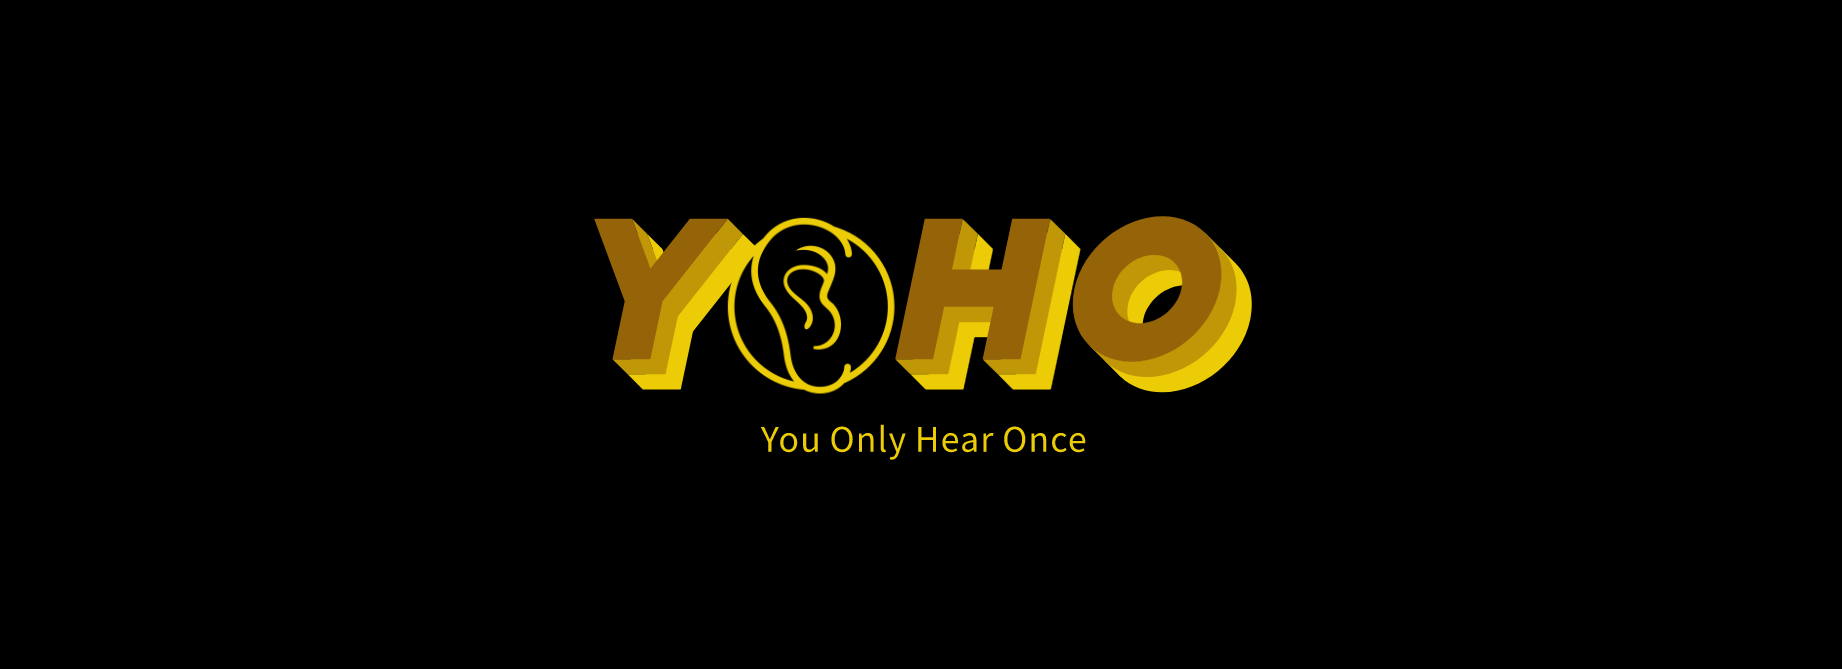

# Introduction
YOHO does object detection in street view and provides audible scene descriptions. With YOHO, a visually impaired person would be able to take out their smartphone, put in their earbuds, and take a walk in the street while their phone lets them know about their surroundings.

YOHO was created via transfer learning and fine-tuning on a YOLOv2 architecture (pre-trained on COCO dataset) on the <a href="https://bdd100k.com" target="_blank">Berkeley Deep Drive dataset</a>, and further, placing an inference engine - **<a href="https://github.com/rezmansouri/tell_a_vision" target="_blank">Tell a Vision</a>** - on top of the model to get audible output from its predictions.

This notebook will depict the implementation. If there are any questions or recommendations, you can reach out to me at <a href="mailto:itsrezamansouri@gmail.com" target="_blank">itsrezamansouri@gmail.com</a> or <a href="mailto:std_reza_mansouri@khu.ac.ir" target="_blank">std_reza_mansouri@khu.ac.ir</a>.



# 1. Obtain anchor boxes
The key idea behind the YOLO (You Only _Look_ Once) algorithm is using anchor boxes. Anchor boxes are basically widths and heights of rectangles that generalize the widths and heights of the objects in our dataset. Accordingly, a YOLO model is able to distinguish between two different overlapping objects easily.

Let's begin! We'll start by downlading the data and gathering the width and height of our objects, and then, performing a _k_-means clustering on them to get our anchor boxes.

## 1.1. Download the data
Run the following cell if you're running the notebook in colab. Otherwise, download the bdd100k dataset directly from their <a href="https://bdd100k.com" target="_blank">website</a> and modify the cell below accordingly.

In [ ]:
!gdown '1RFvDqbObSKWudX1Zh-Rk9SklXYnBTm89' # Download the images zip file
!gdown '1cd4sZaX7rDpBmexZihiAkTyBF1n6oRwH' # Download the labels zip file
!unzip -q '/content/bdd100k_images_100k.zip' # Extract image files
!unzip -q '/content/bdd100k_labels_release.zip' # Extract label files
!rm '/content/bdd100k_images_100k.zip' # Remove the images zip file
!rm '/content/bdd100k_labels_release.zip' # Remove the labels zip file

Downloading...
From: https://drive.google.com/uc?id=1RFvDqbObSKWudX1Zh-Rk9SklXYnBTm89
To: /content/bdd100k_images_100k.zip
100% 5.67G/5.67G [01:16<00:00, 73.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cd4sZaX7rDpBmexZihiAkTyBF1n6oRwH
To: /content/bdd100k_labels_release.zip
100% 112M/112M [00:02<00:00, 53.9MB/s]


## 1.2. Define our desired classes
The BDD100k dataset has many object classes, but we only need the following:

In [ ]:
CLASSES = ['car', 'person', 'bus', 'truck', 'bike', 'rider', 'motor', 'traffic light', 'train']

## 1.3. Read annotations


In [ ]:
import json

In [ ]:
def get_annotations_from_json(file_path: str, classes):
    with open(file_path) as annotations_file:
        annotations_list = json.load(annotations_file)
    annotations_dict = {}
    for annotation in annotations_list:
        new_annotation = []
        for obj in annotation['labels']:
            if 'box2d' not in obj or obj['category'] not in classes:
                # We only want rectangular objects in the desired classes
                continue
            new_obj = {'box': obj['box2d'], 'class': obj['category']}
            new_annotation.append(new_obj)
        annotations_dict[annotation['name']] = new_annotation
    return annotations_dict

In [ ]:
train_annotations_dict = get_annotations_from_json('/content/bdd100k/labels/bdd100k_labels_images_train.json', CLASSES)
val_annotations_dict = get_annotations_from_json('/content/bdd100k/labels/bdd100k_labels_images_val.json', CLASSES)

## 1.4. Inspect the annotations
Lets see what our annotations look like. You'll see the annotations of 2 pictures in our training dataset. However, the annotations object is a dictionary and the keys are the name of the image files for convenience in data manipulation later. 

In [ ]:
from pprint import pprint

In [ ]:
sample = list(train_annotations_dict.values())[:2]
pprint(sample, indent=2)

[ [ { 'box': { 'x1': 1125.902264,
               'x2': 1156.978645,
               'y1': 133.184488,
               'y2': 210.875445},
      'class': 'traffic light'},
    { 'box': { 'x1': 1156.978645,
               'x2': 1191.50796,
               'y1': 136.637417,
               'y2': 210.875443},
      'class': 'traffic light'},
    { 'box': { 'x1': 45.240919,
               'x2': 357.805838,
               'y1': 254.530367,
               'y2': 487.906215},
      'class': 'car'},
    { 'box': { 'x1': 507.82755,
               'x2': 908.367588,
               'y1': 221.727518,
               'y2': 442.715126},
      'class': 'car'}],
  [ { 'box': { 'x1': 423.158909,
               'x2': 434.176547,
               'y1': 336.241987,
               'y2': 358.277263},
      'class': 'person'},
    { 'box': { 'x1': 563.939839,
               'x2': 573.733294,
               'y1': 324.000165,
               'y2': 348.483804},
      'class': 'person'},
    { 'box': { 'x1': 656.977672,
   

## 1.5. Get boxes' dimensions

In [ ]:
import numpy as np

In [ ]:
train_boxes_dims = []
for k in train_annotations_dict:
    for obj in train_annotations_dict[k]:
        height = obj['box']['y2'] - obj['box']['y1']
        width = obj['box']['x2'] - obj['box']['x1']
        train_boxes_dims.append([width, height])
train_boxes_dims = np.asarray(train_boxes_dims, 'float32')
print('train boxes dimensions shape: ', train_boxes_dims.shape)

train boxes dimensions shape:  (1047185, 2)


So now we have 1,047,185 rectangle dimensions of our objects and we're ready to cluster them.

## 1.6. Clustering the boxes
In order to cluster our 1 million boxes, we're going to use the _k_-means algorithm, but we're not going to use euclidean distance for it. Instead, we'll define a new metric to measure the distance between our data points. The IoU<sup> I owe you!</sup> (Intersection over Union).

### 1.6.1. IoU (Intersection over Union)
This metric will measure how close are two bounding boxes dimensions, as a distance function for the _k_-means algorithm.

IoU = The area of intersection (overlap) / The area of union

The figure below, illustrates it.

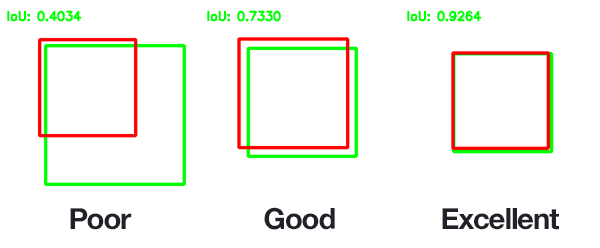

This function will calculate a single box's (named `anch_box`) IoU with a list of boxes (named `boxes`) regarding only the dimensions and not the locations of the boxes. Further we'll define a distance function, which would output the distance of the `anch_box` from all the `boxes` (The more the IoU, the less the distance, makes sense?).

In [ ]:
def iou(anch_box, boxes):
    x = np.minimum(anch_box[0], boxes[:, 0])
    y = np.minimum(anch_box[1], boxes[:, 1])
    intersection = x * y
    anch_box_area = anch_box[0] * anch_box[1]
    boxes_area = boxes[:, 0] * boxes[:, 1]
    union = anch_box_area + boxes_area - intersection
    return intersection / union

In [ ]:
def distance(point, points):
    return 1 - iou(point, points)

### 1.6.2. _k_-means
_k_-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

In [ ]:
def kmeans(samples, n_clusters, distance_func):
    n_samples = samples.shape[0]
    distances = np.empty((n_samples, n_clusters))
    last_clusters = np.zeros((n_samples))
    nearest_clusters = np.full((n_samples), -1)

    clusters = samples[np.random.choice(n_samples, k, replace=False)]

    while not (last_clusters == nearest_clusters).all():
        last_clusters = nearest_clusters
        for i in range(n_clusters):
            distances[:, i] = distance_func(clusters[i], samples)
        nearest_clusters = np.argmin(distances, axis=1)
        for i in range(n_clusters):
            clusters[i] = np.mean(samples[nearest_clusters == i], axis=0)

    return clusters, nearest_clusters, distances

### 1.6.3. Clustering
We don't know how many anchor boxes (clusters) we should have. The more, the better the accuracy (IoU), however we can't have 1 million of them! The less, the better the performance, and we don't want the minimum number of 2 clusters. So it's a trade-off. Let's start by 2 and go till 10 to see what we get. 

In [ ]:
kmax = 11
clustering_results = {}
intercluster_mean_distances = {}
for k in range(2, kmax):
    clusters, nearest_clusters, distances = kmeans(train_boxes_dims, k, distance_func=distance)
    intercluster_mean_distance = np.mean(distances[np.arange(distances.shape[0]), nearest_clusters])
    print('{:2.0f} clusters: mean distance within clusters = {:6.5f}'.format(k, intercluster_mean_distance))
    clustering_results[k] = clusters
    intercluster_mean_distances[k] = intercluster_mean_distance

 2 clusters: mean distance within clusters = 0.58388
 3 clusters: mean distance within clusters = 0.50014
 4 clusters: mean distance within clusters = 0.45192
 5 clusters: mean distance within clusters = 0.42491
 6 clusters: mean distance within clusters = 0.40995
 7 clusters: mean distance within clusters = 0.38085
 8 clusters: mean distance within clusters = 0.36324
 9 clusters: mean distance within clusters = 0.34523
10 clusters: mean distance within clusters = 0.33281


### 1.6.4. Choose the best _k_
As we saw the distances were reducing, but remember the trade-off? Lets choose the best _k_ here and the cluster centroids will be our anchor boxes. Here, we'll plot the intercluster mean distances with their corresponding number of clusters:

In [ ]:
import matplotlib.pyplot as plt

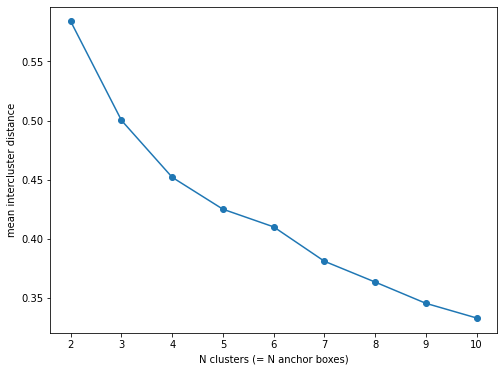

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(2, kmax),
         [intercluster_mean_distances[k] for k in range(2, kmax)],'o-')
plt.ylabel('mean intercluster distance')
plt.xlabel('N clusters (= N anchor boxes)')
plt.show()

To make a decision on how many anchor boxes to use, statisticians often like to see "elbow" curve, in our case, **5** is the answer!

In [ ]:
N_ANCHOR_BOXES = 5
ANCHOR_BOXES = clustering_results[N_ANCHOR_BOXES]
print('Final anchor boxes: \n', ANCHOR_BOXES)

Final anchor boxes: 
 [[ 17.8466    20.21877 ]
 [206.55675  160.90396 ]
 [ 45.473183  46.223682]
 [376.37094  316.30515 ]
 [106.01657   84.53792 ]]


# 2. Data preprocessing
In this section, we'll create our dataset objects (training and validation).

## 2.1. Helper functions
The following function will read a single image, resize it to the given dimensions, and return the normalized image tensor along with its original size (to resize it back and the computed predictions in the future).

In [ ]:
from PIL import Image

In [ ]:
def encode_image(image_path: str, width: int, height: int):
    image = Image.open(image_path)
    image_org_size = image.size
    resized_image = image.resize((width, height), Image.LANCZOS)
    encoded_image = np.asarray(resized_image, dtype='float32') / 255.
    return image_org_size, encoded_image

YOLO devides an input image into grid cells (e.g. 13 by 13 grid cells) and performs image classification and localization algorithms in each grid cell, _all at once_. For example, in a 416px * 416px image, if the center width is 170 pixels, and there are 13 grid cells along the horizontal axis, then the center width must be recorded in grid cell scale as:

$$
170/416*13 = 5.31
$$

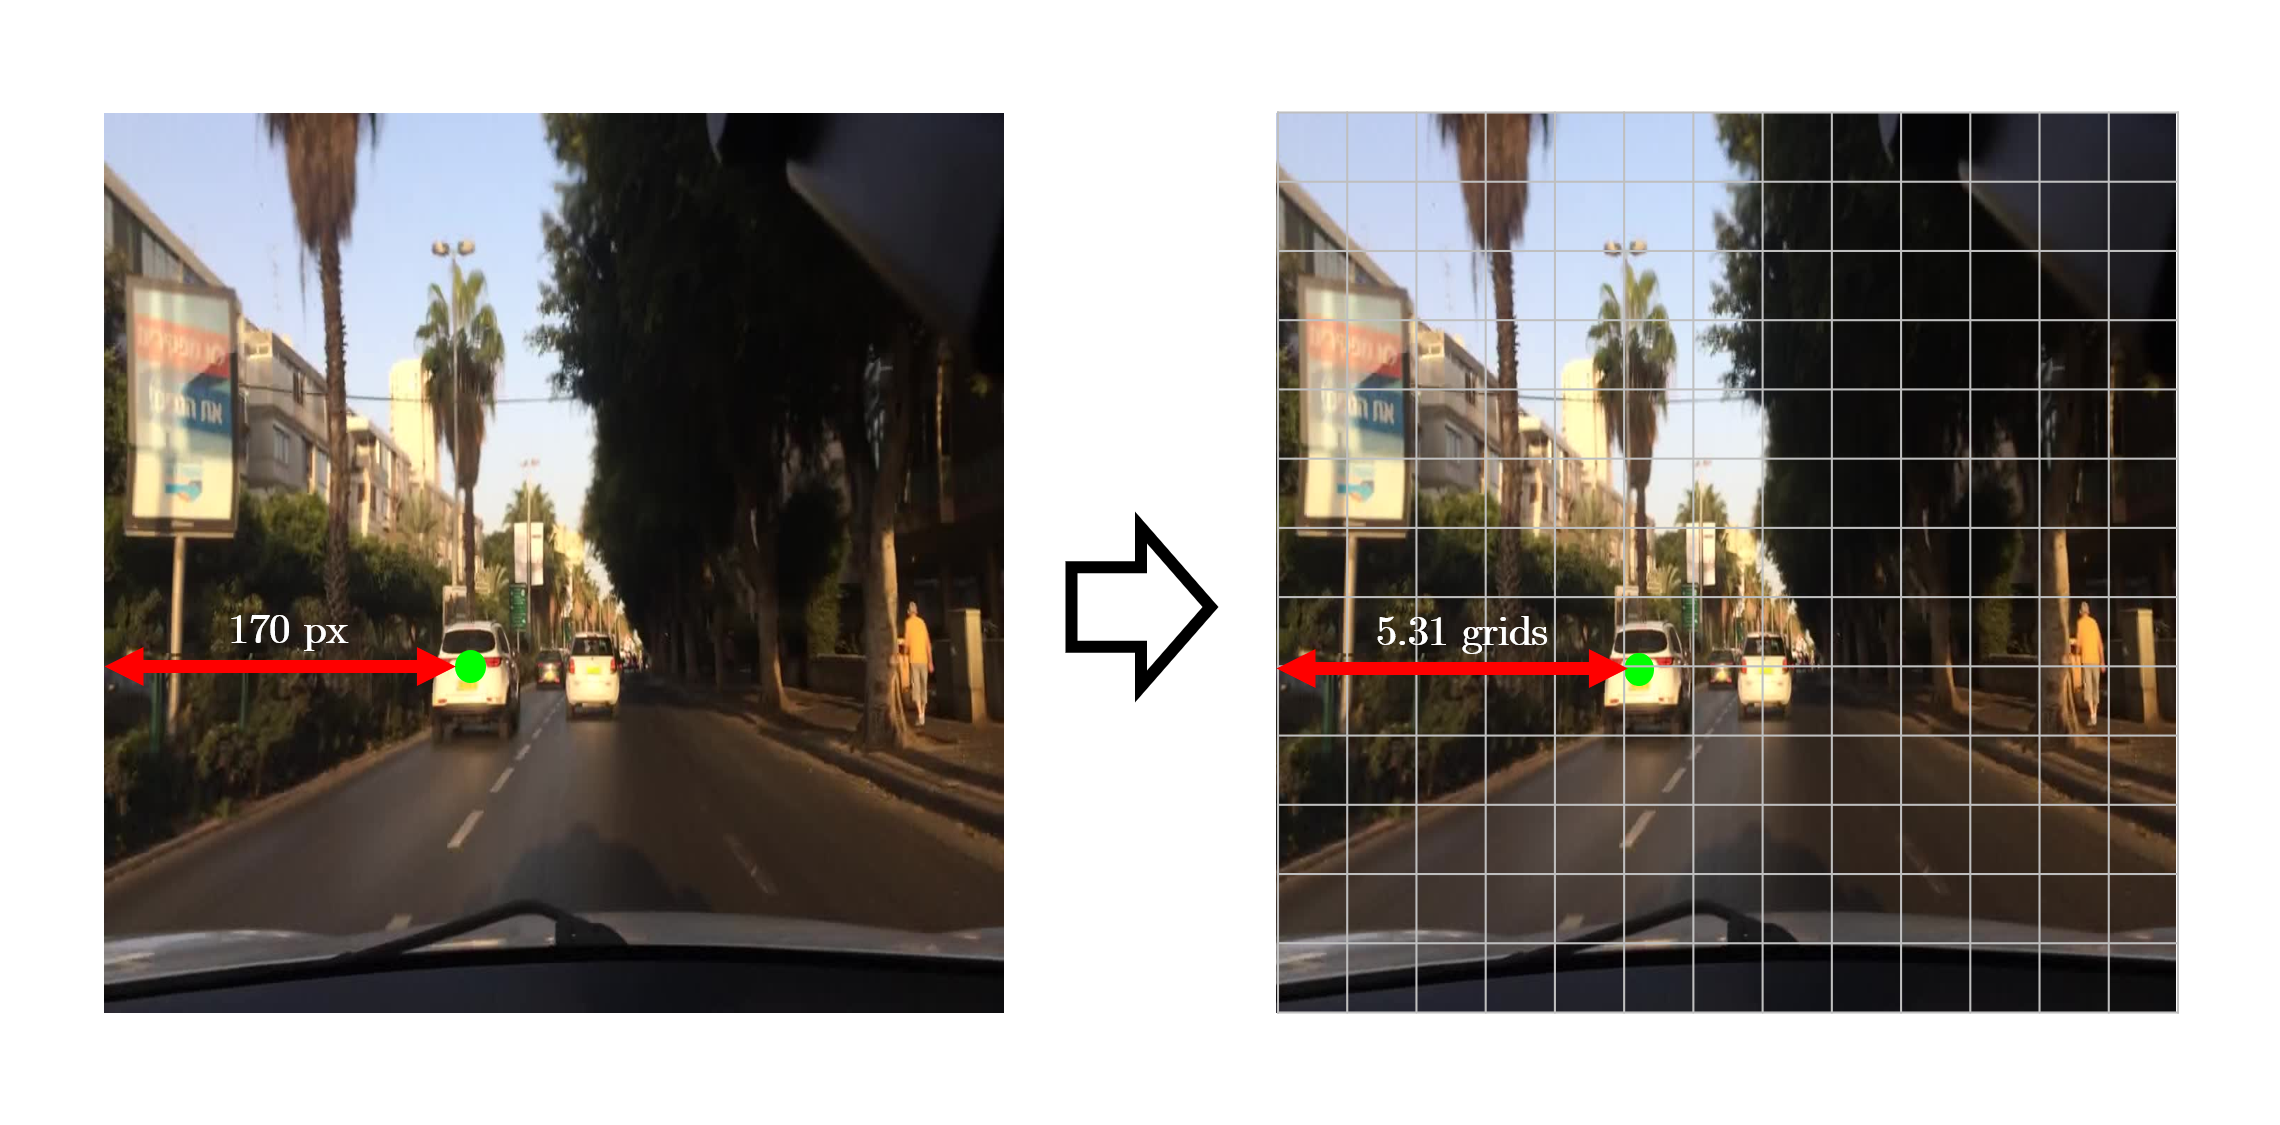

The function below, encodes a training input instance which means, encode the image (using the previous function) and resize the objects' bounding boxes in the annotation accordingly.

In [ ]:
from copy import deepcopy

In [ ]:
def encode_instance(image_path: str, annotation: list, width: int, height: int, n_grids_w: int, n_grids_h: int):
    (org_width, org_height), encoded_image = encode_image(image_path, width, height)
    new_annotation = deepcopy(annotation)
    for obj in new_annotation:
        for attribute in ['x1', 'x2']:
            obj['box'][attribute] = obj['box'][attribute] * n_grids_w / org_width
        for attribute in ['y1', 'y2']:
            obj['box'][attribute] = obj['box'][attribute] * n_grids_h / org_height
    return encoded_image, new_annotation

YOLO uses its own bounding box format which is width and height of the object's center and its width and height, instead of the common (xmin, ymin, xmax, ymax) COCO format.

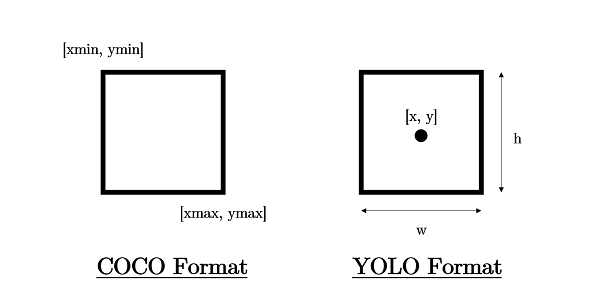

The following function will convert a bounding box's COCO format to YOLO's:

In [ ]:
def edge_box_to_center_box(box: dict):
    x1, x2, y1, y2 = box['x1'], box['x2'], box['y1'], box['y2']
    new_box = {'x': (x1 + x2) / 2.,
               'y': (y1 + y2) / 2.,
               'w': x2 - x1,
               'h': y2 - y1}
    return new_box

In order to create our training labels (y) we need to assign each bounding box in an image to the best anchor box, meaning the anchor box with the highest IoU with the bounding box. The following function will do so:

In [ ]:
def find_best_box(box: dict, anchor_boxes):
    wh = [box['w'], box['h']]
    ious = iou(wh, anchor_boxes)
    return np.argmax(ious)

## 2.2. Batch generator
This is the class that will instantiate our dataset objects. It inherits the `Sequence` class in `keras`. It will basically use the functions in section 2 for a batch of input images and return x, y pairs.

In [ ]:
import tensorflow as tf

In [ ]:
class BatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, images: list, annotations: dict, images_dir: str, cfg: dict, shuffle=True):
        assert 'IMAGE_H' and 'IMAGE_W' and 'N_GRIDS' and 'CLASSES' and 'ANCHOR_BOXES' and 'BATCH_SIZE' in cfg, 'Malformed Config'
        self.cfg = cfg
        self.cfg['N_CLASSES'] = len(self.cfg['CLASSES'])
        self.cfg['N_ANCHOR_BOXES'] = len(self.cfg['ANCHOR_BOXES'])
        self.cfg['N_IMAGES'] = len(images)
        self.images_dir = images_dir
        if not self.images_dir.endswith('/'):
            self.images_dir += '/'
        self.images = images
        self.annotations = annotations
        self.shuffle = shuffle
        if shuffle:
            np.random.shuffle(images)
    
    def __len__(self):
        return self.cfg['N_IMAGES'] // self.cfg['BATCH_SIZE']
        
    def __getitem__(self, idx):
        left_bound = idx * self.cfg['BATCH_SIZE']
        right_bound = (idx + 1) * self.cfg['BATCH_SIZE']
        if right_bound > self.cfg['N_IMAGES']:
            right_bound = self.cfg['N_IMAGES']
            left_bound = right_bound - self.cfg['BATCH_SIZE']
        x_batch = np.zeros((self.cfg['BATCH_SIZE'], self.cfg['IMAGE_H'], self.cfg['IMAGE_W'], 3))
        y_batch = np.zeros((self.cfg['BATCH_SIZE'], self.cfg['N_GRIDS'], self.cfg['N_GRIDS'], self.cfg['N_ANCHOR_BOXES'], 1 + 4 + self.cfg['N_CLASSES']))
        for instance_count, image_name in enumerate(self.images[left_bound:right_bound]):
            image, new_annotation = encode_instance(self.images_dir + image_name, self.annotations[image_name], 
                                                    self.cfg['IMAGE_W'], self.cfg['IMAGE_H'],
                                                    self.cfg['N_GRIDS'], self.cfg['N_GRIDS'])
            true_box_index = 0
            for obj in new_annotation:
                single_point_coords = edge_box_to_center_box(obj['box'])
                box = [single_point_coords['x'], single_point_coords['y'], single_point_coords['w'], single_point_coords['h']]
                class_index = self.cfg['CLASSES'].index(obj['class'])
                best_anchor = find_best_box(single_point_coords, self.cfg['ANCHOR_BOXES'])
                grid_x = int(box[0])
                grid_y = int(box[1])
                y_batch[instance_count, grid_y, grid_x, best_anchor, :4] = box
                y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1.
                y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + class_index] = 1.

            x_batch[instance_count] = image

        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)

## 2.3. Configurations
First, lets rescale our anchor boxes just like we'll do with objects' bounding boxes:

In [ ]:
N_GRIDS = 13
ORG_W = 1280 # Our dataset images are 1280 pixels wide
ORG_H = 720  # Our dataset images are 720 pixels high

ANCHOR_BOXES_RESCALED = np.empty((ANCHOR_BOXES.shape), dtype='float32')
ANCHOR_BOXES_RESCALED[:, 0] = ANCHOR_BOXES[:, 0] * N_GRIDS / ORG_W
ANCHOR_BOXES_RESCALED[:, 1] = ANCHOR_BOXES[:, 1] * N_GRIDS / ORG_H
print('Rescaled anchor boxes: \n', ANCHOR_BOXES_RESCALED)

Rescaled anchor boxes: 
 [[0.18125454 0.3650611 ]
 [2.097842   2.9052103 ]
 [0.461837   0.8345943 ]
 [3.8225174  5.711065  ]
 [1.0767308  1.5263791 ]]


YOLO's input is squared shaped images. Thus, we'll resize our 1280 x 720 images to 416 x 416 images which if downscaled n times `(416->208->104->52->26->13)`, we'll have our 13 x 13 grid desired output.

In [ ]:
cfg = {
    'IMAGE_H': 416,
    'IMAGE_W': 416,
    'N_GRIDS': N_GRIDS,
    'CLASSES': CLASSES,
    'ANCHOR_BOXES': ANCHOR_BOXES_RESCALED,
    'BATCH_SIZE': 32
}

Training set:

In [ ]:
train_images_dir = '/content/bdd100k/images/100k/train'
train_image_names = list(train_annotations_dict.keys())
train_batch_generator = BatchGenerator(train_image_names, train_annotations_dict, train_images_dir, cfg)

Validation set:

In [ ]:
val_images_dir = '/content/bdd100k/images/100k/val'
val_image_names = list(val_annotations_dict.keys())
val_batch_generator = BatchGenerator(val_image_names, val_annotations_dict, val_images_dir, cfg)

## 2.4. Inspect the dataset
Let's see what our generators generate:

In [ ]:
x_batch, y_batch = train_batch_generator.__getitem__(0)
print('x_batch shape:', x_batch.shape)
print('y_batch shape:', y_batch.shape)

x_batch shape: (32, 416, 416, 3)
y_batch shape: (32, 13, 13, 5, 14)


Why the shape of `y_batch` is `(32, 13, 13, 5, 14)`?
- 32 is our batch size
- 13 and 13 are the grids
- 5 is the number of anchor boxes
- 14 is: 4 + 1 + 9
    - 4: The predicted bounding box: (x, y, w, h)
    - 1: The confidence of an objects presence
    - 9: Class confidence scores (We have 9 classes)

Lets visually output an input instance. These colors correspond to our classes respectively:

In [ ]:
COLORS = ['red', 'orange', 'yellow', 'cyan', 'blue', 'white', 'pink', 'lightgreen', 'purple']
#        ['car', 'person', 'bus', 'truck', 'bike', 'rider', 'motor', 'traffic light', 'train']

The following functions will illustrate an input image (x) and depict the corresponding label (y) accordingly:

In [ ]:
def plot_img_with_box(irow):
    img = x_batch[irow]
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    for wh in ['w', 'h']:
        grid = 13
        img = 416
        if wh == 'w':
            pltax = plt.axvline
            plttick = plt.xticks
        else:
            pltax = plt.axhline
            plttick = plt.yticks
        for count in range(grid):
            l = img * count / grid
            pltax(l, color=(0, 1, 0, .3))
        plttick([(i + 0.5) * img / grid for i in range(grid)],
                ['{}={}'.format(wh, i) for i in range(grid)])


def plot_grid(irow):
    iobj = 0
    for igrid_h in range(cfg['N_GRIDS']):
        for igrid_w in range(cfg['N_GRIDS']):
            for ianchor in range(cfg['N_ANCHOR_BOXES']):
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                C = vec[4]
                if C == 1:
                    class_num = np.where(vec[5:])[0][0]
                    color = COLORS[class_num]
                    x, y, w, h = vec[:4]
                    multx = cfg['IMAGE_W'] / cfg['N_GRIDS']
                    multy = cfg['IMAGE_H'] / cfg['N_GRIDS']
                    xmin = x - 0.5 * w
                    ymin = y - 0.5 * h
                    xmax = x + 0.5 * w
                    ymax = y + 0.5 * h
                    plt.plot(x * multx, y * multy,
                             'o', color=color)
                    plt.plot(np.array([xmin, xmin]) * multx,
                             np.array([ymin, ymax]) * multy, color=color, linewidth=2)
                    plt.plot(np.array([xmin, xmax]) * multx,
                             np.array([ymin, ymin]) * multy, color=color, linewidth=2)
                    plt.plot(np.array([xmax, xmax]) * multx,
                             np.array([ymax, ymin]) * multy, color=color, linewidth=2)
                    plt.plot(np.array([xmin, xmax]) * multx,
                             np.array([ymax, ymax]) * multy, color=color, linewidth=2)


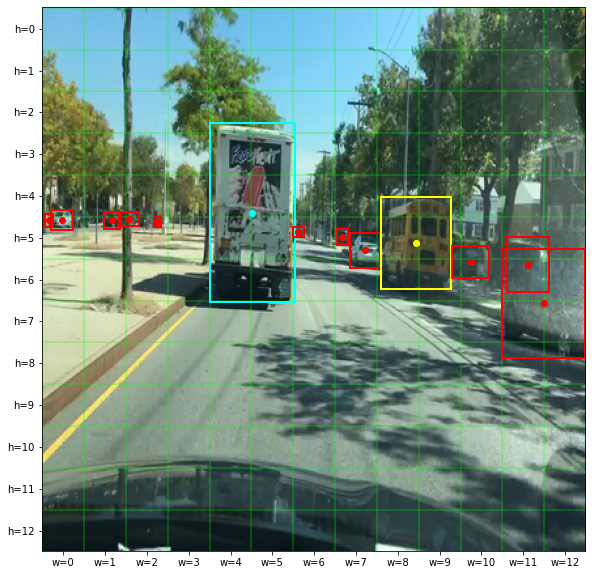

In [ ]:
index = 5 # Change this between 0 and 31 to explore different images in the first training batch
plot_img_with_box(index)
plot_grid(index)
plt.show()

# 3. Architecture
In this section we'll first define our model, set the last two layers as trainable (transfer learning on the last one, fine-tuning the one before), and loading the pre-trained weights on the COCO dataset.

## 3.1. Model
YOLOv2's architecture simply does this:

1. Take a 416 x 416 x 3 volume as input.
2. Downsample it 5 times, getting a 13 x 13 x 1024 output.
3. Get the final 13 x 13 x 5 x (4 + 1 + 9) output through 1-by-1 convolutions.

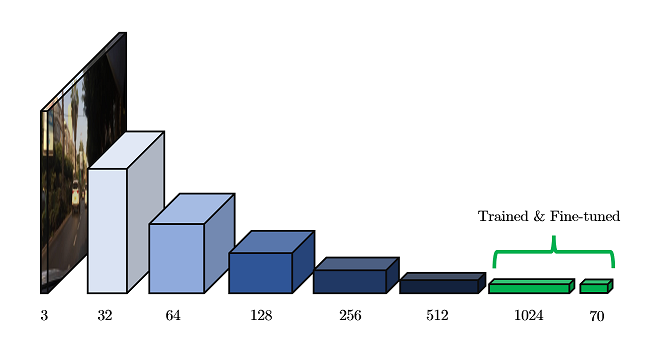

First, lets define our model. The building blocks of our model contain the following layers:
1. 3x3 Convolutions with same padding
2. Batch normalization
3. Activation layer: Leaky ReLU
4. 2x2 Maxpooling

In [ ]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model, Sequential

In [ ]:
def reorganize(x):
    return tf.nn.space_to_depth(x, block_size=2) # This is a small hack to reshape the final output volume

In [ ]:
def yolo_model(image_h, image_w, n_grids, n_anchor_boxes, n_classes):
    input_image = tfl.Input((image_h, image_w, 3), name='image')
    # 1
    x = tfl.Conv2D(32, (3, 3), padding='same', use_bias=False, name='conv_1', trainable=False)(input_image)
    x = tfl.BatchNormalization(name='batchnorm_1', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.MaxPool2D(name='maxpool_1')(x)
    # 2
    x = tfl.Conv2D(64, (3, 3), padding='same', use_bias=False, name='conv_2', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_2', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.MaxPool2D(name='maxpool_2')(x)
    # 3
    x = tfl.Conv2D(128, (3, 3), padding='same', use_bias=False, name='conv_3', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_3', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(64, (1, 1), padding='same', use_bias=False, name='conv_4', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_4', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(128, (3, 3), padding='same', use_bias=False, name='conv_5', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_5', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.MaxPool2D(name='maxpool_3')(x)
    # 4
    x = tfl.Conv2D(256, (3, 3), padding='same', use_bias=False, name='conv_6', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_6', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(128, (1, 1), padding='same', use_bias=False, name='conv_7', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_7', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(256, (3, 3), padding='same', use_bias=False, name='conv_8', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_8', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.MaxPool2D(name='maxpool_4')(x)
    # 5
    x = tfl.Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_9', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_9', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(256, (1, 1), padding='same', use_bias=False, name='conv_10', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_10', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_11', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_11', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(256, (1, 1), padding='same', use_bias=False, name='conv_12', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_12', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_13', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_13', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    # skip connection
    skip_conn = x
    x = tfl.MaxPool2D(name='maxpool_5')(x)
    # 6
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_14', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_14', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(512, (1, 1), padding='same', use_bias=False, name='conv_15', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_15', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_16', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_16', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(512, (1, 1), padding='same', use_bias=False, name='conv_17', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_17', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_18', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_18', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_19', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_19', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_20', trainable=False)(x)
    x = tfl.BatchNormalization(name='batchnorm_20', trainable=False)(x)
    x = tfl.LeakyReLU(.1)(x)
    # skip connection
    skip_conn = tfl.Conv2D(64, (1, 1), padding='same', use_bias=False, name='conv_21', trainable=False)(skip_conn)
    skip_conn = tfl.BatchNormalization(name='batchnorm_21', trainable=False)(skip_conn)
    skip_conn = tfl.LeakyReLU(.1)(skip_conn)
    skip_conn = tfl.Lambda(reorganize, name='reorganize')(skip_conn)
    # 7
    x = tfl.concatenate([skip_conn, x])
    x = tfl.Conv2D(1024, (3, 3), padding='same', use_bias=False, name='conv_22', trainable=True)(x)
    x = tfl.BatchNormalization(name='batchnorm_22', trainable=True)(x)
    x = tfl.LeakyReLU(.1)(x)
    x = tfl.Conv2D(n_anchor_boxes * (1 + 4 + n_classes), (1, 1), padding='same', use_bias=True, name='conv_23', trainable=True)(x)
    output = tfl.Reshape((n_grids, n_grids, n_anchor_boxes, (1 + 4 + n_classes)))(x)

    model = Model(inputs=input_image, outputs=output)
    return model

In [ ]:
training_model = yolo_model(cfg['IMAGE_H'], cfg['IMAGE_W'], cfg['N_GRIDS'], cfg['N_ANCHOR_BOXES'], cfg['N_CLASSES'])
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 416, 416, 32  128        ['conv_1[0][0]']                 
 n)                             )                                                             

We only set the last two conv layers + the batch norm in between to be trained. lets see the model's trainable layers:

In [ ]:
for var in training_model.trainable_variables:
    print(var.name, 'shape:', var.shape)

conv_22/kernel:0 shape: (3, 3, 1280, 1024)
batchnorm_22/gamma:0 shape: (1024,)
batchnorm_22/beta:0 shape: (1024,)
conv_23/kernel:0 shape: (1, 1, 1024, 70)
conv_23/bias:0 shape: (70,)


## 3.2. Weights
In this section, we'll load the pre-trained weights on the COCO dataset and initialize the final conv layer.

### 3.2.1. Loading pre-trained weights
First, lets download the weights from Joseph Chet Redmon's website:

In [ ]:
!wget 'https://pjreddie.com/media/files/yolov2.weights'

--2022-10-29 07:05:56--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  60.1MB/s    in 3.4s    

2022-10-29 07:06:00 (56.6 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



Now lets load the weights to our model. We'll set the weights for all the layers but the last one which will be manually initialized. The next two cells are from <a href="https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb" target="_blank">experiencor</a>'s tutorial.

In [ ]:
class WeightReader:
    
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [ ]:
def set_pretrained_weight(model, nb_conv, path_to_weight):
    weight_reader = WeightReader(path_to_weight)
    weight_reader.reset()
    for i in range(1, nb_conv+1):
        
        conv_layer = model.get_layer('conv_' + str(i))

        if i < nb_conv:
            norm_layer = model.get_layer('batchnorm_' + str(i))

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)

            weights = norm_layer.set_weights([gamma, beta, mean, var])    

        if len(conv_layer.get_weights()) > 1: # with bias
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else: # without bias
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])

    return model

Using `set_pretrained_weight` we'll load the weights only up to the 23rd conv layer:

In [ ]:
training_model = set_pretrained_weight(training_model, 22, '/content/yolov2.weights')

### 3.2.2. Initializing last layer's weights
Now lets initialize the last conv layer's weights and biases. We'll do so using a normal distribution:

In [ ]:
def initialize_weight(layer, scale):
    weights = layer.get_weights()
    new_kernel = np.random.randn(*weights[0].shape) * scale
    new_bias   = np.zeros(weights[1].shape)
    layer.set_weights([new_kernel, new_bias])

In [ ]:
layer = training_model.get_layer('conv_23')
initialize_weight(layer, 1e-4)

Now our model is ready to be trained.

# 4. Loss function
YOLOv2's loss function is fairly complicated, and it is not documented in its <a href="https://arxiv.org/abs/1612.08242" target="_blank">paper</a>. On the other hand, the original YOLO has a roughly simpler one. Our loss function looks more like the original YOLO's than YOLOv2's. Lets see.

## 4.1. Rescaling the output


The output has a shape of (13, 13, 5, 14), _which is equivalent to (13, 13, 70) before being reshaped_. This volume can contain any real number because there is no activation layer after it. The reason is that each element in the last axis (14) has a different boundry. For example, we want our confidence scores to be between 0 and 1, whereas x, y, w, and h are in grid scale.

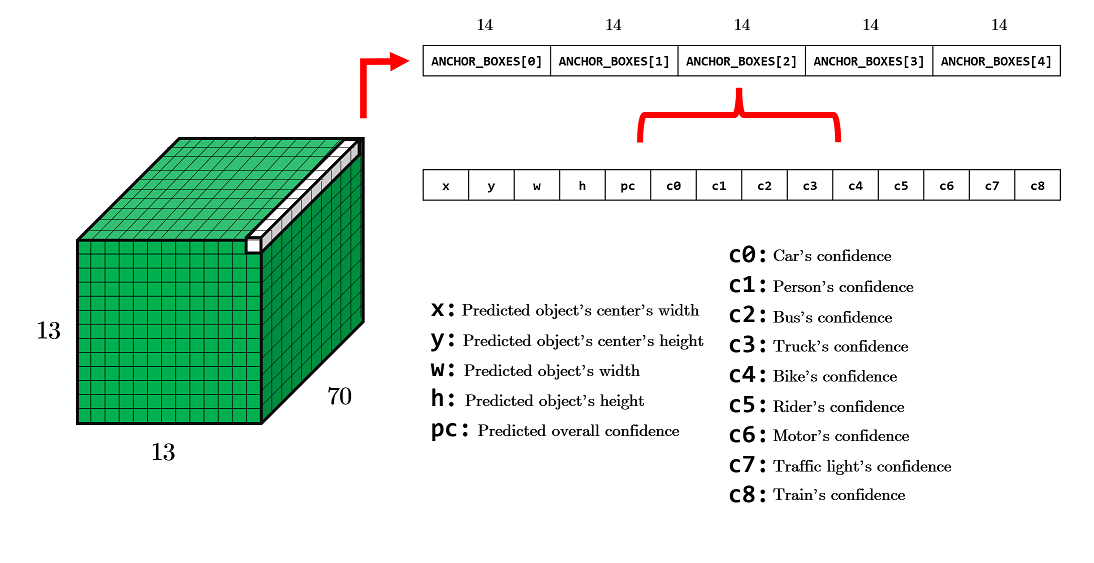

The boundries are as follows:

1. `x` in `igrid_x` is in [`igrid_x`, `igrid_x + 1`) range
2. `y` in `igrid_y` is in [`igrid_y`, `igrid_y + 1`) range
3. `w` is in [`0`, `N_GRIDS`) range
4. `h` is in [`0`, `N_GRIDS`) range
5. `pc` is in [`0`, `1`] range
6. `c[:]` is in [`0`, `1`] range

\* `N_GRIDS` in YOHO is 13.

Thus, we need to rescale the final output volume according to each element's boundaries.

x and y will first be scaled to be in between 0 and 1. Afterwards, a matrix for x and another for y will be created such that their boundaries are correct.

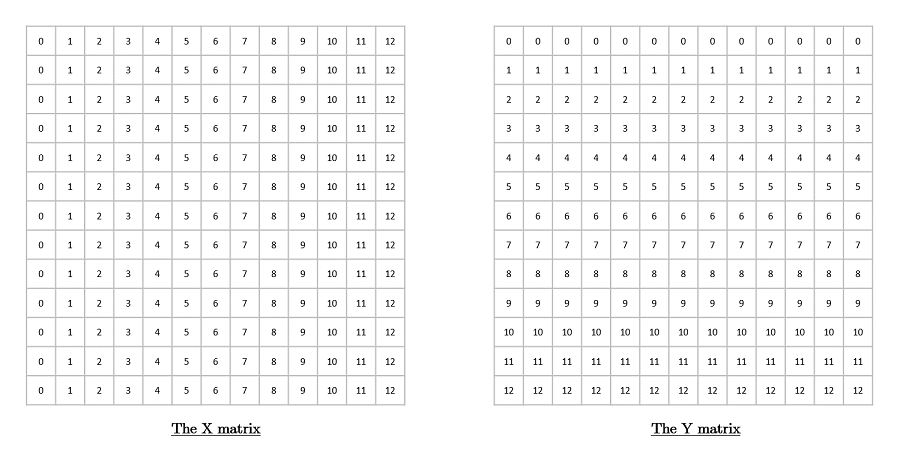

The following function will create those matrices in the same shape as the final output volume to be added to its x and y elements:

In [ ]:
def get_intercept_vol(n_grids, batch_size, n_anchor_boxes):
    x_mat = tf.cast(
        tf.reshape(
            tf.tile(tf.range(n_grids), [n_grids]),
            (1, n_grids, n_grids, 1, 1)),
        dtype=tf.float32)
    y_mat = tf.transpose(x_mat, [0, 2, 1, 3, 4])
    mat = tf.concat([x_mat, y_mat], -1)
    vol = tf.tile(mat, [batch_size, 1, 1, n_anchor_boxes, 1])
    return vol

1. We'll use the sigmoid function to first scale x and y in between 0 and 1, add the intercept volume to them.
2. We'll use the exponential of the calculated w and h values (to avoid negative values) and multiply them by our anchor boxes widths and heights.
3. We'll use the sigmoid function to scale overall confidence in between 0 and 1.
4. We'll use the softmax function for our class confidence scores.

In [ ]:
def rescale_preds(y_pred, intercept_vol, anchor_boxes):
    pred_xy = tf.sigmoid(y_pred[..., :2]) + intercept_vol # step 1
    pred_wh = tf.exp(y_pred[..., 2:4]) * tf.reshape(anchor_boxes, [1, 1, 1, -1, 2]) # step 2
    pred_pc = tf.sigmoid(y_pred[..., 4]) # step 3
    pred_c = tf.nn.softmax(y_pred[..., 5:]) # step 4
    return pred_xy, pred_wh, pred_pc, pred_c

## 4.2. Loss for x, y, w, and h
This part of our loss function is calculated as follows:

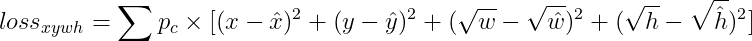

In [ ]:
def xywh_loss(true_pc, true_xy, true_wh, pred_xy, pred_wh):
    mask_obj = tf.expand_dims(true_pc, -1)
    xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy) * mask_obj)
    wh_loss = tf.reduce_sum(tf.square(tf.sqrt(true_wh) - tf.sqrt(pred_wh)) * mask_obj)
    return xy_loss + wh_loss

## 4.3. Loss for p<sub>c</sub>
This part of our loss function is calculated as follows:

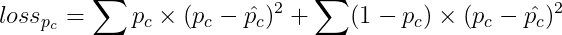

The $(1-p_{c})$ part in the second sum accounts for training the model when it predicted an objects presence while there is none.

In [ ]:
def pc_loss(true_pc, pred_pc):
    mask_obj = true_pc
    mask_noobj = (1 - mask_obj)
    loss_1 = tf.reduce_sum(tf.square(true_pc - pred_pc) * mask_obj)
    loss_2 = tf.reduce_sum(tf.square(true_pc - pred_pc) * mask_noobj)
    return loss_1 + loss_2

## 4.4. Loss for c<sub>0</sub>, c<sub>1</sub>,..., c<sub>8</sub>
This part of our loss function is calculated as follows:

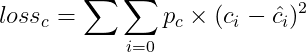

In [ ]:
def c_loss(true_pc, true_c, pred_c):
    mask_obj = tf.expand_dims(true_pc, axis=-1)
    loss = tf.reduce_sum(tf.square(true_c - pred_c) * mask_obj)
    return loss

## 4.5. Getting the ground truth
We need a function to extract `true_xy`, `true_wh`, `true_pc`, and `true_c` from y in a batch of input:

In [ ]:
def get_ground_truth(y_true):
    true_xy = y_true[..., :2]
    true_wh = y_true[..., 2:4]
    true_pc = y_true[..., 4]
    true_c = y_true[..., 5:]
    return true_xy, true_wh, true_pc, true_c

## 4.6. Final loss

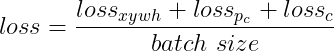


The following function is the sum of all the losses above: 

In [ ]:
def loss_core(y_true, y_pred, n_grids, batch_size, anchor_boxes):
    intercept_vol = get_intercept_vol(n_grids, batch_size, len(anchor_boxes))
    pred_xy, pred_wh, pred_pc, pred_c = rescale_preds(y_pred, intercept_vol, anchor_boxes)
    true_xy, true_wh, true_pc, true_c = get_ground_truth(y_true)
    xywh_l = xywh_loss(true_pc, true_xy, true_wh, pred_xy, pred_wh)
    class_l = c_loss(true_pc, true_c, pred_c)
    confidence_l = pc_loss(true_pc, pred_pc)
    loss = (xywh_l + class_l + confidence_l) / batch_size
    return loss

Tensorflow's loss functions only have two arguments, y (`y_true`) and $\hat{y}$ (`y_pred`). So we need a wrapper:

In [ ]:
def loss(y_true, y_pred):
    return loss_core(y_true, y_pred, cfg['N_GRIDS'], cfg['BATCH_SIZE'], ANCHOR_BOXES_RESCALED)

# 5. Training
For this section, you may either train the network for yourself, if you have enough resources available (try GPU accelerators on Colab), or you can load the pre-trained weights. Go to section 5.2 if you're willing to do so. 

## 5.1. Training the model
First, lets compile the model with our custom loss function and the *adam* optimizer.

In [ ]:
training_model.compile(loss=loss, optimizer='adam')

Lets train the model for 22 epochs (It will overfit after the 22nd):

In [ ]:
training_model.fit(x=train_batch_generator,
          steps_per_epoch  = len(train_batch_generator), 
          epochs           = 22,
          verbose          = 1,
          validation_data  = val_batch_generator,
          validation_steps = len(val_batch_generator),
          max_queue_size   = 1)

## 5.2. Loading the pre-trained model
I have trained a model for 22 epochs. Lets download the weights and load them:

In [ ]:
!gdown '1eHIHQ6WRwvK-JJFWCOdXUKBMUFupfgdG' # downloading the weights
pre_trained_model = yolo_model(cfg['IMAGE_H'], cfg['IMAGE_W'], cfg['N_GRIDS'], cfg['N_ANCHOR_BOXES'], cfg['N_CLASSES']) # instantiating an architecture
pre_trained_model.load_weights('/content/pre-trained-weights.h5') # loading the weights

Downloading...
From: https://drive.google.com/uc?id=1eHIHQ6WRwvK-JJFWCOdXUKBMUFupfgdG
To: /content/pre-trained-weights.h5
100% 298M/298M [00:05<00:00, 57.7MB/s]


## 5.3. Inspecting the training history
We trained our model (or loaded the pre-trained model) for 22 epochs. Why didn't we continue? Becuase the validation loss stops to decrease around this time, meaning overfitting. This approach to avoid overfitting is called _early stopping_. You can see how the losses would have changed if we had kept going on for 77 epochs instead of 22.

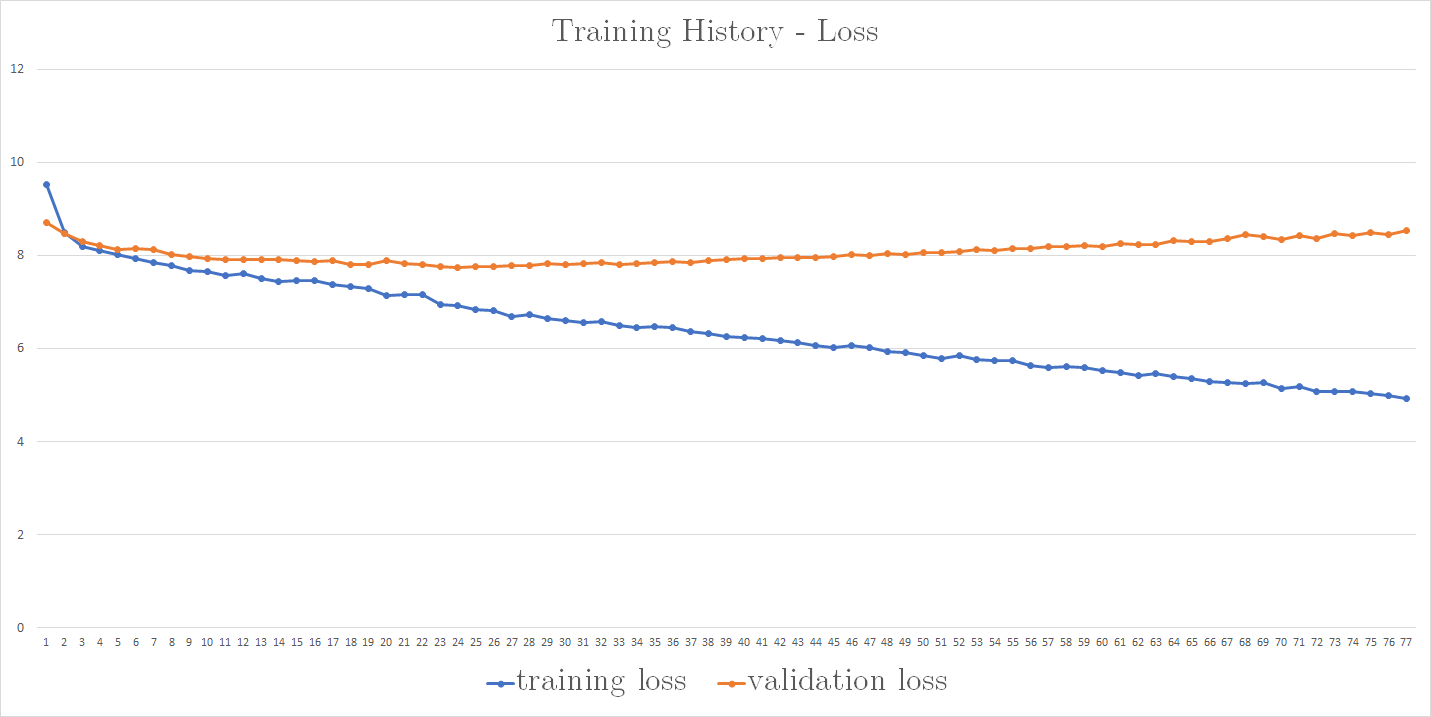

# 6. Inference
This section will turn the model's predicted volume into presentable result.

## 6.1. Filtering the output
We need to filter the predicted presence of objects in the output volume according to a pre-defined threshold value. Meaning we'll ignore the predicted objects if their confidence score is lower than our threshold. This confidence score is: the overall confidence score ($p_{c}$) times class confidence scores ($c_{0}, ... c_{8}$). We'll first calculate these final scores and take the max of them to distinguish the class object, and the apply the threshold on all the grids and anchor boxes. We'll basically do this:

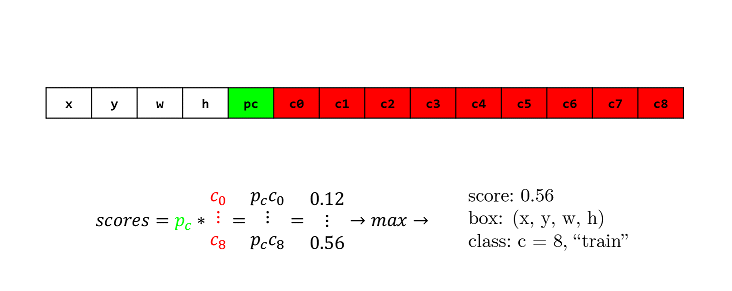

In [ ]:
def filter_output(boxes, overall_confidence, class_confidence, threshold):

    box_scores = tf.expand_dims(overall_confidence, axis=-1) * class_confidence
    box_classes = tf.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    
    filtering_mask = box_class_scores > threshold

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

## 6.2. Non-max suppression
Non-max suppression is an algorithm that prunes away boxes that have high intersection-over-union (IoU) overlap with previously selected boxes.

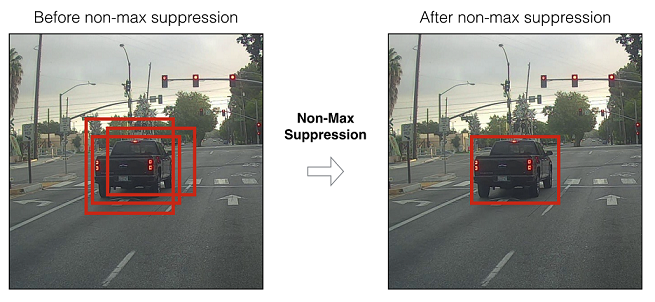

We'll use tensorflow's implementation:

In [ ]:
def non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold = 0.5):
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    return scores, boxes, classes

Tensorflow's `non_max_suppression` requires our boxes to be in COCO format. The following function will change bounding box coordinates from YOLO format back to COCO's. It will also arrange the elements such that the result is a tensor of `[ymin, xmin, ymax, xmax]` values which is what tensorflow requires:

In [ ]:
def center_to_edge_coords(yx, hw):
    halves = hw / 2.
    mins = yx - halves
    maxes = yx + halves
    return tf.concat([mins, maxes], axis=-1)

We need to define how many objects we want our model to detect at the maximum:

In [ ]:
MAX_OBJS = 5

## 6.3. Prediction
This function will use the functions above to obtain the final results from a single image:

In [ ]:
def predict(model, image_path, anchor_boxes, confidence_threshold = .4, max_boxes = MAX_OBJS):
    (image_org_width, image_org_height), image = encode_image(image_path, cfg['IMAGE_W'], cfg['IMAGE_H'])
    image_tensor = tf.expand_dims(image, axis=0)
    raw_preds = model.predict(image_tensor)
    intercept_vol = get_intercept_vol(cfg['N_GRIDS'], 1, cfg['N_ANCHOR_BOXES'])
    xy, wh, pc, c = rescale_preds(raw_preds, intercept_vol, anchor_boxes)
    xywh = tf.concat([xy, wh], axis=-1)
    scores, yolo_boxes, classes = filter_output(xywh, pc, c, confidence_threshold)
    yolo_boxes = yolo_boxes.numpy()
    yx, hw = yolo_boxes[:, [1, 0]], yolo_boxes[:, [3, 2]]
    coco_boxes = center_to_edge_coords(yx, hw)
    nms_scores, nms_boxes, nms_classes = non_max_suppression(scores, coco_boxes, classes, max_boxes)
    return (image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes

## 6.4. Visual Inference
The following function will plot the image and the predicted objects:

In [ ]:
def plot_prediction(image, image_org_width, image_org_height, n_grids, boxes, classes):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    image_file = Image.fromarray((image * 255.).astype('uint8'))
    image_file = image_file.resize((image_org_width, image_org_height))
    image_out = np.asarray(image_file)
    plt.imshow(image_out)
    for i, box in enumerate(boxes):
        ymin, xmin, ymax, xmax = box
        multx = image_org_width / n_grids
        multy = image_org_height / n_grids
        color = COLORS[classes[i]]
        plt.plot(np.array([xmin, xmin]) * multx,
                 np.array([ymin, ymax]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmin, xmax]) * multx,
                 np.array([ymin, ymin]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmax, xmax]) * multx,
                 np.array([ymax, ymin]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmin, xmax]) * multx,
                 np.array([ymax, ymax]) * multy, color=color, linewidth=3)
    plt.show()

Lets make some predictions!

<sup>Run the following two cells according to whether you trained the model for yourself, or loaded the pre-trained model (sections 5.1 and 5.2)</sup>

In [ ]:
# Run this cell if you want to make predictions using the training model
model = training_model
anchor_boxes = ANCHOR_BOXES_RESCALED

In [ ]:
# Run this one instead if you want to see the pre-trained model's predictions
model = pre_trained_model
anchor_boxes = np.asarray([[4.093997, 5.9909186],
                           [1.9559963, 2.879731],
                           [0.4287669, 0.7933745],
                           [1.013704, 1.3656671],
                           [0.17043826, 0.35517225]], dtype='float32')
 # The anchor boxes were obtained using a subset of the training set, thus they do not correspond with the ones obtained in this notebook

### 6.4.1. Example one
Lets see the prediction for an image in our **training** set.

1/1 [==============================] - 2s 2s/step


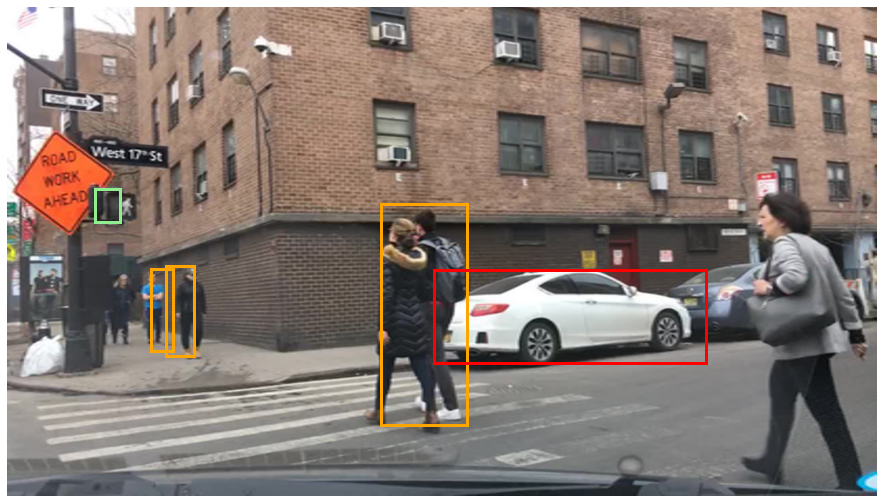

In [ ]:
image_path = '/content/bdd100k/images/100k/train/' + train_image_names[12]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes)
plot_prediction(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

### 6.4.2. Example two
Lets see another prediction for an image in our **training** set.

1/1 [==============================] - 1s 645ms/step


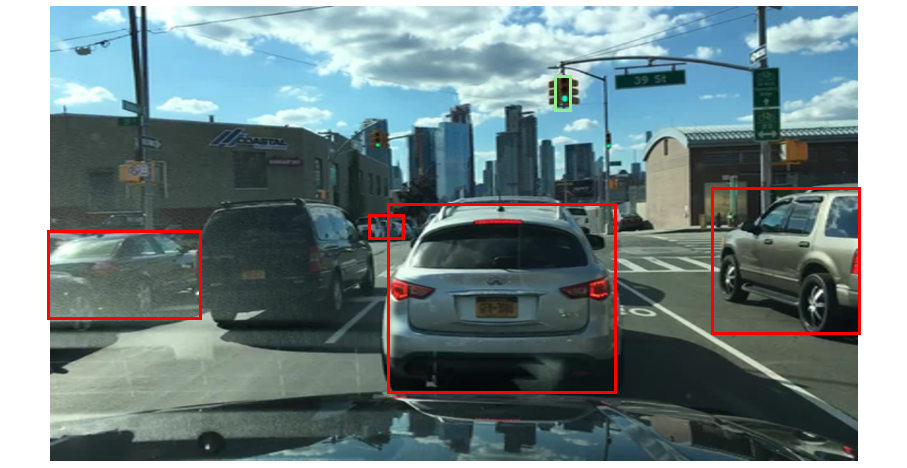

In [ ]:
image_path = '/content/bdd100k/images/100k/train/' + train_image_names[21]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes)
plot_prediction(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

### 6.4.3. Example three
Lets see the prediction for an image in our **validation** set.

1/1 [==============================] - 1s 631ms/step


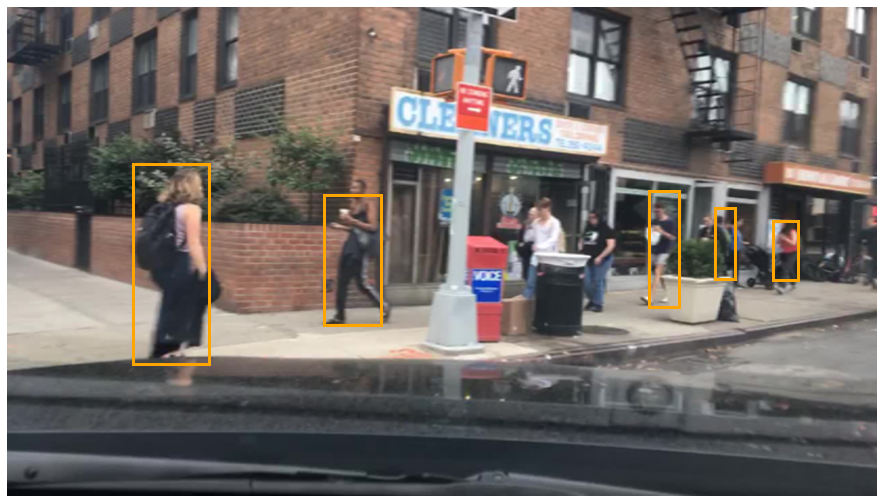

In [ ]:
image_path = '/content/bdd100k/images/100k/val/' + val_image_names[700]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes)
plot_prediction(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

### 6.4.3. Example four
Lets see another prediction for an image in our **validation** set.

1/1 [==============================] - 1s 615ms/step


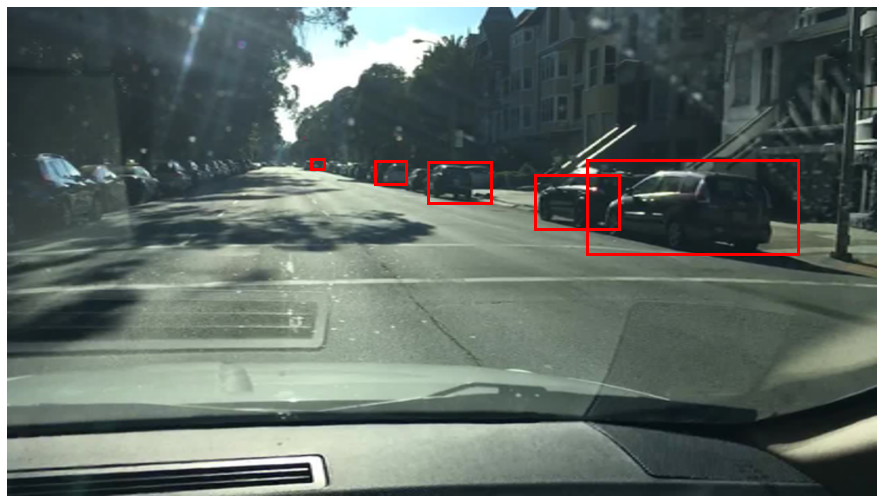

In [ ]:
image_path = '/content/bdd100k/images/100k/val/' + val_image_names[32]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes)
plot_prediction(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

Pretty accurate right?! Now lets hear them!

## 6.5. Audible inference
This is the part where YOLO becomes YOHO. So far we've trained a convolutional neural network (via transfer learning and fine-tuning) which is able to detect objects in street view. Now we want to hear descriptions of what the CNN is seeing. Here's the complete architecture of YOHO: 

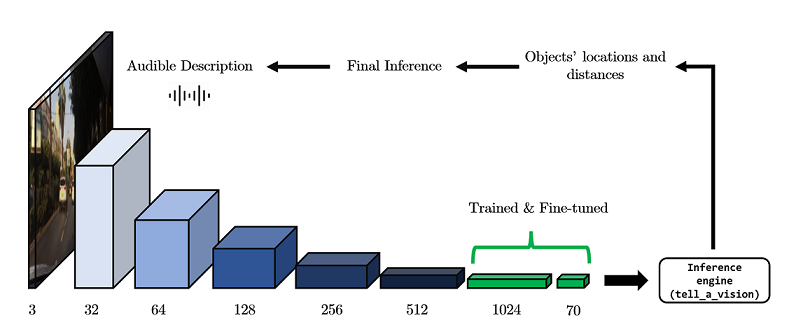

### 6.5.1. Tell a Vision

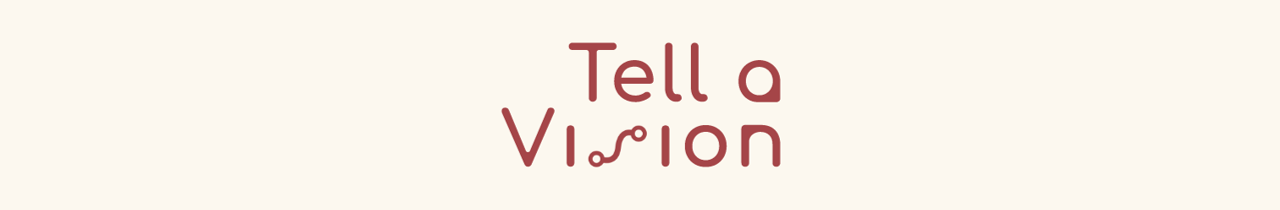

**tell a vision (`tv`)**  is an inference engine, in the form of a Python package that describes the scenes for object detection tasks in computer vision. We'll use it to get audible output from YOLO.

Links:
- <a href="https://pypi.org/project/tell-a-vision/" target = "_blank">tell-a-vision on PyPI</a>
- <a href="https://github.com/rezmansouri/tell_a_vision/" target = "_blank">GitHub Repository</a>
- <a href="https://colab.research.google.com/drive/1o6MgntmIb1qLLpGXxsDw0W6SMH2kheCZ?usp=sharing#scrollTo=lq2FiYAAqVHU" target = "_blank">Demo on Colab</a>

#### 6.5.1.1. Installation

In [ ]:
!pip install --upgrade tell_a_vision

#### 6.5.1.2. Detect object distances
`tell_a_vision` has a `Ruler` class which fits on a dataset to learn the objects size ranges. It will extract their quartiles so it will be able to tell if an object is far (small) or near (big):

In [ ]:
import tell_a_vision as tv

We need to create a list of our annotation values:

In [ ]:
training_bounding_boxes = list(train_annotations_dict.values())

This is what the `Ruler` will learn:

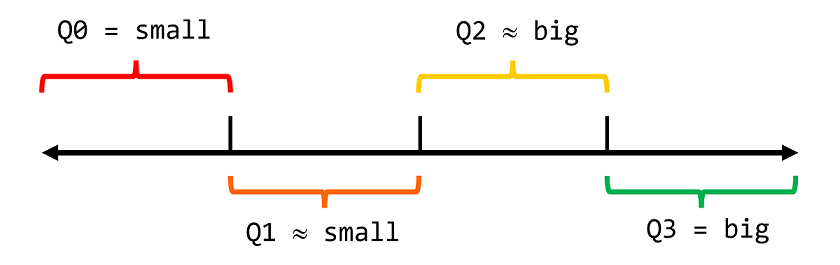

Now we'll instantiate a `Ruler` object. It takes the bounding boxes along with our class labels to get the quartile ranges.

In [ ]:
ruler = tv.Ruler(training_bounding_boxes, CLASSES)

#### 6.5.1.3. Narrations
`tv` has a `Narrator` class which downloads all the possible narrations specific to your class labels in `.mp3` format. It will later be able to infer from `tv`'s other results such as `Ruler`'s to obtain a description of the input scene.

In [ ]:
narrator = tv.Narrator(CLASSES, '/content/narrations')

#### 6.5.1.4. Rescale boxes
Our model predicted bounding boxes are in `N_GRIDS` scale. We need to scale them back using the function below for `tv`:

In [ ]:
def rescale_boxes(boxes, org_width, org_height, n_grids):
    rescaled_boxes = deepcopy(boxes)
    rescaled_boxes[:, [0, 2]] *= org_height / n_grids 
    rescaled_boxes[:, [1, 3]] *= org_width / n_grids
    return rescaled_boxes

#### 6.5.1.4. Helper functions
The following functions are just used to show the results:

In [ ]:
import IPython

In [ ]:
def plot_prediction_with_bounds(image, image_org_width, image_org_height, n_grids, boxes, classes):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    image_file = Image.fromarray((image * 255.).astype('uint8'))
    image_file = image_file.resize((image_org_width, image_org_height))
    image_out = np.asarray(image_file)
    plt.imshow(image_out)
    for i, box in enumerate(boxes):
        ymin, xmin, ymax, xmax = box
        multx = image_org_width / n_grids
        multy = image_org_height / n_grids
        color = COLORS[classes[i]]
        plt.plot(np.array([xmin, xmin]) * multx,
                 np.array([ymin, ymax]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmin, xmax]) * multx,
                 np.array([ymin, ymin]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmax, xmax]) * multx,
                 np.array([ymax, ymin]) * multy, color=color, linewidth=3)
        plt.plot(np.array([xmin, xmax]) * multx,
                 np.array([ymax, ymax]) * multy, color=color, linewidth=3)
    plt.plot([image_org_width/2, image_org_width/2], [0, image_org_height], color=(0,1,0,0.7), linewidth=1)
    plt.plot([0, image_org_width], [image_org_height/2, image_org_height/2], color=(0,1,0,0.7), linewidth=1)
    plt.show()

In [ ]:
def display_audio(files, directory):
    for file in files:
        IPython.display.display(IPython.display.Audio(f'{directory}/{file}.mp3'))

### 6.5.2. Example one
Lets see and hear the results on one of our **training** images.

1/1 [==============================] - 1s 599ms/step


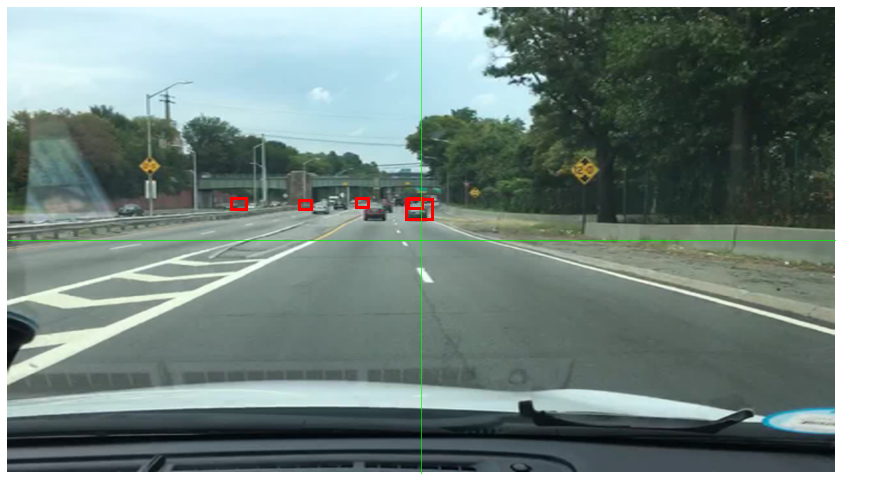

In [ ]:
image_path = '/content/bdd100k/images/100k/train/' + train_image_names[112]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes, max_boxes=MAX_OBJS)
plot_prediction_with_bounds(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

rescaled_boxes = rescale_boxes(nms_boxes.numpy(), image_org_width, image_org_height, cfg['N_GRIDS'])

locations = tv.locate(rescaled_boxes, image_org_width, image_org_height)
ranks = ruler.get_ranks(rescaled_boxes, nms_classes)
narrations = narrator.get_narration(nms_classes, CLASSES, ranks, locations)
display_audio(narrations, '/content/narrations')

### 6.5.3. Example two
Lets see and hear the results on another **training** image.

1/1 [==============================] - 1s 602ms/step


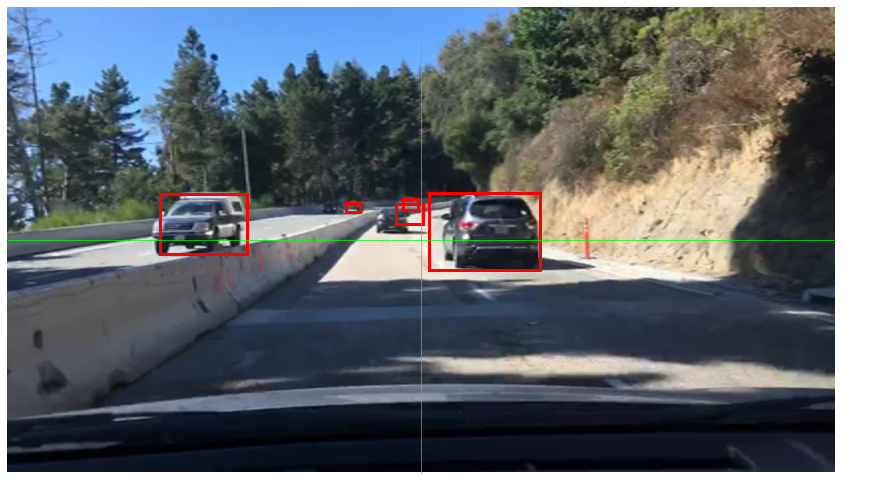

In [ ]:
image_path = '/content/bdd100k/images/100k/train/' + train_image_names[117]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes, max_boxes=MAX_OBJS)
plot_prediction_with_bounds(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

rescaled_boxes = rescale_boxes(nms_boxes.numpy(), image_org_width, image_org_height, cfg['N_GRIDS'])

locations = tv.locate(rescaled_boxes, image_org_width, image_org_height)
ranks = ruler.get_ranks(rescaled_boxes, nms_classes)
narrations = narrator.get_narration(nms_classes, CLASSES, ranks, locations)
display_audio(narrations, '/content/narrations')

### 6.5.4. Example three
Lets see and hear the results on one of our **validation** images.

1/1 [==============================] - 1s 615ms/step


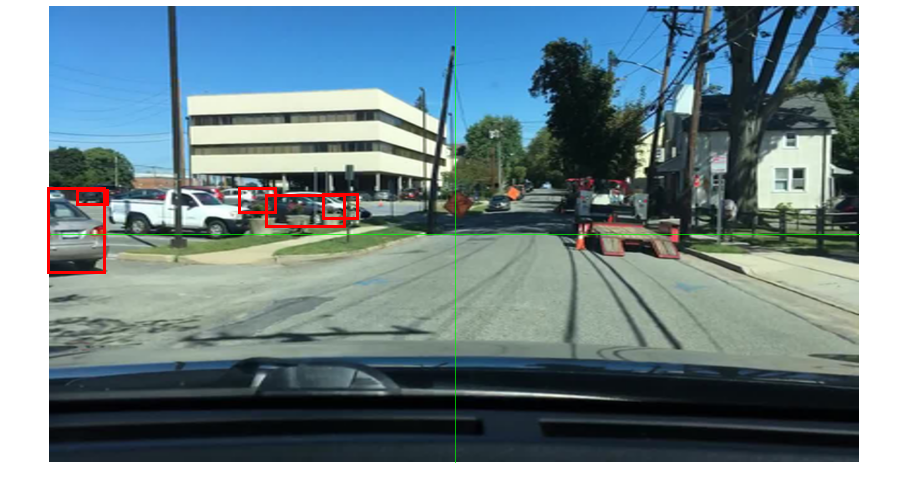

In [ ]:
image_path = '/content/bdd100k/images/100k/val/' + val_image_names[233]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes, max_boxes=MAX_OBJS)
plot_prediction_with_bounds(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

rescaled_boxes = rescale_boxes(nms_boxes.numpy(), image_org_width, image_org_height, cfg['N_GRIDS'])

locations = tv.locate(rescaled_boxes, image_org_width, image_org_height)
ranks = ruler.get_ranks(rescaled_boxes, nms_classes)
narrations = narrator.get_narration(nms_classes, CLASSES, ranks, locations)
display_audio(narrations, '/content/narrations')

### 6.5.5. Example four
Lets see and hear the results on another one of our **validation** images.

1/1 [==============================] - 1s 614ms/step


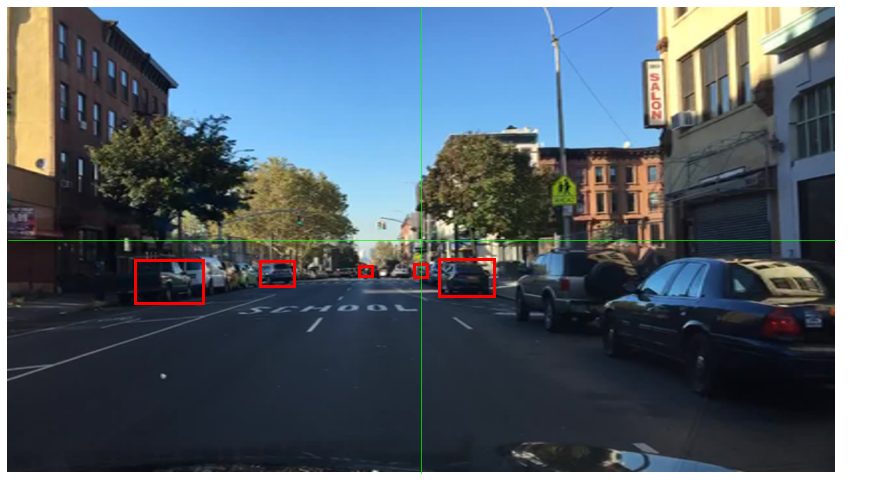

In [ ]:
image_path = '/content/bdd100k/images/100k/val/' + val_image_names[271]
(image_org_width, image_org_height), image, nms_scores, nms_boxes, nms_classes = predict(model, image_path, anchor_boxes, max_boxes=MAX_OBJS)
plot_prediction_with_bounds(image, image_org_width, image_org_height, cfg['N_GRIDS'], nms_boxes, nms_classes)

rescaled_boxes = rescale_boxes(nms_boxes.numpy(), image_org_width, image_org_height, cfg['N_GRIDS'])

locations = tv.locate(rescaled_boxes, image_org_width, image_org_height)
ranks = ruler.get_ranks(rescaled_boxes, nms_classes)
narrations = narrator.get_narration(nms_classes, CLASSES, ranks, locations)
display_audio(narrations, '/content/narrations')